# Clustering de documents

## Imports

In [3]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [4]:
import nltk

nltk.download('punkt')
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
data_path = "../data/txt/"

## Choisir une décennie

In [6]:
DECADE = '1950'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [7]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [8]:
# Exemple de fichiers
files[:35]

['KB_JB1051_1950-03-30_01-00003.txt',
 'KB_JB1051_1950-12-15_01-00003.txt',
 'KB_JB1051_1951-02-14_01-00006.txt',
 'KB_JB1051_1951-07-26_01-00002.txt',
 'KB_JB1051_1951-07-28_01-00003.txt',
 'KB_JB1051_1951-11-17_01-00003.txt',
 'KB_JB1051_1952-02-05_01-00001.txt',
 'KB_JB1051_1952-02-16_01-00001.txt',
 'KB_JB1051_1952-02-20_01-00003.txt',
 'KB_JB1051_1952-02-21_01-00003.txt',
 'KB_JB1051_1952-02-26_01-00003.txt',
 'KB_JB1051_1952-02-29_01-00003.txt',
 'KB_JB1051_1953-11-04_01-00004.txt',
 'KB_JB1051_1954-05-26_01-00002.txt',
 'KB_JB1051_1955-10-06_01-00003.txt',
 'KB_JB1051_1957-04-30_01-00003.txt',
 'KB_JB1051_1957-09-20_01-00003.txt',
 'KB_JB1051_1958-04-02_01-00004.txt',
 'KB_JB1051_1959-01-07_01-00003.txt',
 'KB_JB1051_1959-08-27_01-00003.txt',
 'KB_JB421_1950-10-23_01-00001.txt',
 'KB_JB421_1950-12-02_01-00005.txt',
 'KB_JB421_1950-12-17_01-00002.txt',
 'KB_JB427_1950-02-17_01-00002.txt',
 'KB_JB427_1950-03-29_01-00004.txt',
 'KB_JB427_1950-04-03_01-00006.txt',
 'KB_JB427_1950-04

In [9]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [10]:
# Exemple de textes
texts[0][:400]

'30 mort 1950 mmvimmwm. CRISE jjans l\'industrie Icharbonnière belge confirme FO.N.D. La concurrence allemande encouragée par Washington LES U. S. A. ONT ACCAPARE LES DEBOUCHES EN EUROPE - OUEST A Commission économique pour l\'Europe de l\'O.N.U. a • publie un rapport sur la si- houillère en Europe occi I dentale, qui -- souffert, dit le rap- J e la plus irr".ortante surdon de charbo-** et de coke Bon'

## Vectoriser les documents à l'aide de TF-IDF

In [11]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [12]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [13]:
tfidf_vectors = vectorizer.fit_transform(texts)

c:\Users\Admin\Tac_Test\tac\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [14]:
# Détail de la matrice
tfidf_vectors

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 139336 stored elements and shape (166, 4063)>

### Imprimer le vecteur tf-IDF du premier document

In [15]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

marshall       0.155365
yougoslavie    0.131247
aujourd'hui    0.122217
d'ordre        0.114936
judiciaire     0.111312
                 ...   
énergie        0.000000
énorme         0.000000
énormes        0.000000
épargne        0.000000
1/2            0.000000
Length: 4063, dtype: float64

## Comprendre les vecteurs et leurs "distances"

In [16]:
cosine([1, 2, 3], [1, 2, 3])

np.float64(0.0)

In [17]:
cosine([1, 2, 3], [1, 2, 2])

np.float64(0.02004211298777725)

In [18]:
cosine([1, 2, 3], [2, 2, 2])

np.float64(0.07417990022744858)

### Tests sur nos documents

In [19]:
tfidf_array = tfidf_vectors.toarray()

In [20]:
# Vecteur du document 0
tfidf_array[0]

array([0.        , 0.01878702, 0.        , ..., 0.        , 0.        ,
       0.07874791], shape=(4063,))

In [21]:
# Vecteur du document 1
tfidf_array[1]

array([0.        , 0.        , 0.        , ..., 0.02064829, 0.        ,
       0.        ], shape=(4063,))

In [22]:
cosine(tfidf_array[0], tfidf_array[1])

np.float64(0.71269487800954)

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [23]:
N_CLUSTERS = 3

### Instancier le modèle K-Means et ses arguments

In [24]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [25]:
clusters = km_model.fit_predict(tfidf_vectors)

In [26]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [27]:
pprint(dict(clustering))

{np.int32(0): ['KB_JB638_1950-03-09_01-00001.txt',
               'KB_JB837_1950-11-07_01-00004.txt',
               'KB_JB838_1950-01-13_01-00002.txt',
               'KB_JB838_1950-02-11_01-00005.txt',
               'KB_JB838_1950-08-04_01-00004.txt',
               'KB_JB838_1950-09-10_01-00002.txt',
               'KB_JB838_1950-10-18_01-00004.txt',
               'KB_JB838_1951-01-06_01-00005.txt',
               'KB_JB838_1951-03-07_01-00004.txt',
               'KB_JB838_1951-04-06_01-00002.txt',
               'KB_JB838_1951-04-30_01-00003.txt',
               'KB_JB838_1951-10-06_01-00001.txt',
               'KB_JB838_1951-12-13_01-00002.txt',
               'KB_JB838_1952-01-27_01-00002.txt',
               'KB_JB838_1952-02-15_01-00001.txt',
               'KB_JB838_1952-02-22_01-00003.txt',
               'KB_JB838_1952-03-11_01-00001.txt',
               'KB_JB838_1952-03-12_01-00002.txt',
               'KB_JB838_1952-03-20_01-00004.txt',
               'KB_JB838_1952-0

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [28]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [29]:
reduced_vectors[:10]

array([[-0.07810025, -0.1163425 ],
       [-0.12664781, -0.2044249 ],
       [-0.03404455, -0.19892741],
       [-0.00651864, -0.24025569],
       [-0.09133778, -0.24564663],
       [-0.07618933, -0.2346501 ],
       [ 0.00812795, -0.19337781],
       [-0.0256074 , -0.30867978],
       [-0.09188851, -0.24330468],
       [-0.10834573, -0.29879348]])

### Générer le plot

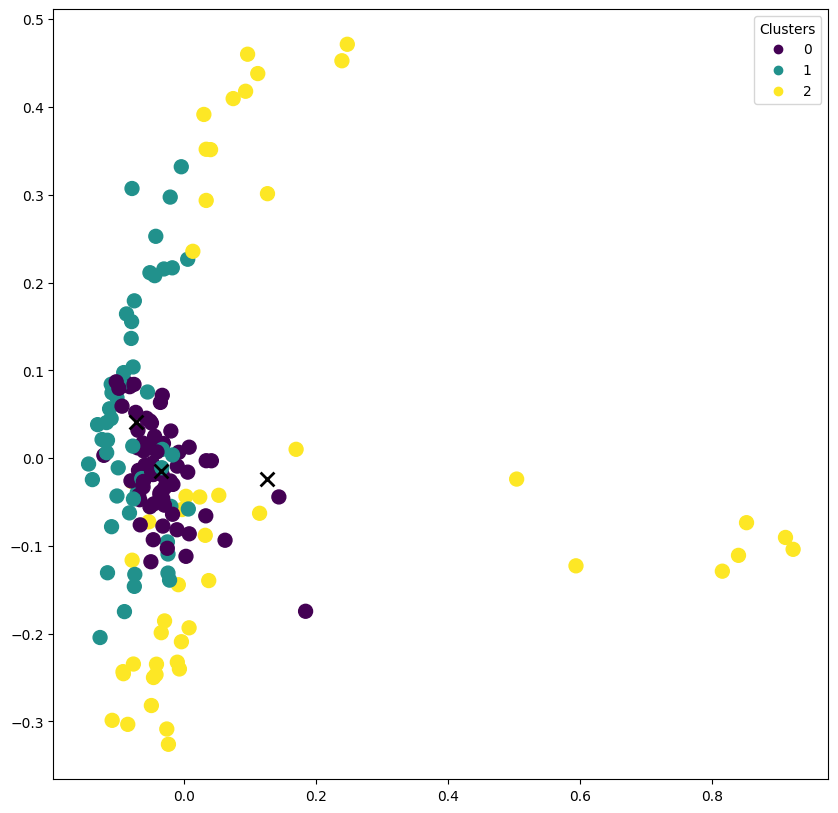

In [30]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")